In [27]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'ece697ls/assignments/assignment3/'
FOLDERNAME = 'ECE_562/Lab_1' # Corrected folder name
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content

ModuleNotFoundError: No module named 'google'

# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = x.dot(w)
  # Do some more computations ...
  out = z
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = dout.dot(w.T)
  dw = x.T.dot(dout)
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from ece662.classifiers.fc_net import *
from ece662.data_utils import get_CINIC10_data
from ece662.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ece662.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython


def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CINIC10 data - Note that CINIC10 was modified in size for this course

data = get_CINIC10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

print('Number of Classes: {}'.format(len(np.unique(data['y_train']))))

('X_train: ', (53973, 3, 32, 32))
('y_train: ', (53973,))
('X_val: ', (10195, 3, 32, 32))
('y_val: ', (10195,))
('X_test: ', (10196, 3, 32, 32))
('y_test: ', (10196,))
Number of Classes: 6


# Affine layer: forward
Open the file `ece697ls/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [30]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769848888397517e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [31]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [32]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [33]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. Tanh

## Answer:

Both activation functions have this problem.
1. Sigmoid  
Derivative of sigmoid function is $\sigma'(x)=\sigma(x)(1 - \sigma(x))$ and since sigmoid function is defined as $\frac{1}{1+e^{-x}}$, then as input $|x| \to \infty$ sigmoid function would saturates at 0 or 1. Thus, $\sigma'(x)$ would be vanished.

2. Tanh  
Derivative of tanh function is $\tanh'(x) = 1- \tanh^2(x)$. Then as input $|x|\to \infty$, tanh function would saturates at -1 or 1 and $\tanh'(x)$ would be vanished.


## Inline Question 2:

Why is an activation function required ? Why is a bias required ?

## Answer:

Activation function is required because:  
- Wihtout activation function, a deep neural network would collapse into single linear layer. Then stacking more layers doesn't add modeling power.
- Nonlinearity lets the network model interactions and complex shapes.

Bias is required because:  
- Shift the function, then we would be able to manipulate the decision boundary.
- Biases give each neuron its own offset so multiple neurons don’t learn identical weight patterns.

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `ece697ls/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [34]:
from ece662.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.395535042049294e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `ece697ls/layers.py`.

You can make sure that the implementations are correct by running the following:

In [35]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `ece697ls/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [36]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.53e-08
W2 relative error: 3.37e-10
b1 relative error: 8.01e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.35e-08
b2 relative error: 1.97e-09


In [37]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)
print(model.params['W2'])

[[ 7.85459586e-04  5.20032672e-04 -4.78305739e-04 -2.04063507e-04
  -9.55564906e-04 -1.68961142e-03  3.74758972e-04]
 [ 8.20229504e-04 -1.85007976e-03  8.24187219e-04 -1.28956103e-03
  -1.50314505e-03 -1.36002559e-03  1.34741254e-03]
 [ 7.34303416e-04 -1.66135415e-03  1.07564149e-03  1.25593369e-03
   2.92560482e-03  1.03904582e-03  3.86337081e-04]
 [-2.90788833e-04  2.27638827e-03  9.64397661e-04 -1.32027378e-03
  -5.52127608e-04  9.93469539e-04  1.94313667e-04]
 [ 1.60200785e-03 -1.47107931e-03 -7.78053067e-04  2.53695942e-03
   1.08655384e-03 -1.74624569e-04 -3.60674008e-05]
 [ 1.92217255e-04 -3.12582976e-04  7.05512422e-04 -1.51141762e-03
  -7.86332164e-04  6.25484042e-05 -6.11195450e-04]
 [-1.13407635e-04  6.70924504e-04  8.94814105e-04 -1.21165094e-05
   9.41243147e-04  4.27411871e-04 -1.70588218e-03]
 [ 1.24092424e-03 -1.05897990e-03  4.65943603e-05 -1.99813645e-04
   2.93020374e-04  1.18131754e-04  1.39208744e-03]
 [-1.15282160e-03  1.93803585e-03 -8.75902499e-04 -1.24067765e-0

# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `ece697ls/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `40%` accuracy on the validation set.

In [33]:
model = TwoLayerNet(
    num_classes=6,
    weight_scale=2e-2,
)

solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(
    model, 
    data, 
    update_rule='adam',
    optim_config={'learning_rate': 5e-4},
    lr_decay=0.95,
    batch_size=300,
    num_epochs=30,
    print_every=100,
    verbose=True
)

solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4620) loss: 14.338047
(Epoch 0 / 30) train acc: 0.185000; val_acc: 0.177930
(Iteration 101 / 4620) loss: 2.239879
(Epoch 1 / 30) train acc: 0.371000; val_acc: 0.343796
(Iteration 201 / 4620) loss: 1.615406
(Iteration 301 / 4620) loss: 1.407946
(Epoch 2 / 30) train acc: 0.411000; val_acc: 0.366062
(Iteration 401 / 4620) loss: 1.363080
(Epoch 3 / 30) train acc: 0.441000; val_acc: 0.380383
(Iteration 501 / 4620) loss: 1.414491
(Iteration 601 / 4620) loss: 1.375518
(Epoch 4 / 30) train acc: 0.466000; val_acc: 0.380088
(Iteration 701 / 4620) loss: 1.418790
(Epoch 5 / 30) train acc: 0.499000; val_acc: 0.397155
(Iteration 801 / 4620) loss: 1.246427
(Iteration 901 / 4620) loss: 1.336449
(Epoch 6 / 30) train acc: 0.464000; val_acc: 0.398921
(Iteration 1001 / 4620) loss: 1.392575
(Epoch 7 / 30) train acc: 0.477000; val_acc: 0.407455
(Iteration 1101 / 4620) loss: 1.320718
(Iteration 1201 / 4620) loss: 1.207771
(Epoch 8 / 30) train acc: 0.508000; val_acc: 0.403531
(Iteration 1301 / 

KeyboardInterrupt: 

# PyTorch Implementation of TwoLayerNet

Now let's implement a TwoLayerNet using PyTorch. This will give us access to automatic differentiation and GPU acceleration.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class TwoLayerNetPyTorch(nn.Module):
    """
    A two-layer fully-connected neural network implemented in PyTorch.
    
    The architecture is: input - fully connected layer - ReLU - fully connected layer - softmax
    
    The outputs of the second fully-connected layer are the scores for each class.
    """
    
    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=6):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero.
        
        Inputs:
        - input_dim: The dimension D of the input data.
        - hidden_dim: The number of neurons H in the hidden layer.
        - num_classes: The number of classes C.
        """
        super(TwoLayerNetPyTorch, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        # Initialize weights with small random values
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x):
        """
        Compute the forward pass.
        
        Inputs:
        - x: Input data of shape (N, D)
        
        Returns:
        - scores: Output scores of shape (N, C)
        """
        # Flatten input if needed
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        
        # Forward pass: input -> fc1 -> relu -> fc2
        x = self.fc1(x)
        x = self.relu(x)
        scores = self.fc2(x)
        
        return scores


def train_pytorch_model(model, train_data, val_data, num_epochs=20, batch_size=100, 
                       learning_rate=1e-3, weight_decay=0.0, device='cpu'):
    """
    Train a PyTorch model.
    
    Inputs:
    - model: PyTorch model to train
    - train_data: Tuple of (X_train, y_train)
    - val_data: Tuple of (X_val, y_val)
    - num_epochs: Number of training epochs
    - batch_size: Batch size for training
    - learning_rate: Learning rate for optimizer
    - weight_decay: L2 regularization strength
    - device: Device to train on ('cpu' or 'cuda')
    
    Returns:
    - Dictionary containing training history
    """
    model = model.to(device)
    
    # Prepare data
    X_train, y_train = train_data
    X_val, y_val = val_data
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    print("Starting training...")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
        
        # Calculate training accuracy
        train_acc = 100. * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            _, val_predicted = val_outputs.max(1)
            val_correct = val_predicted.eq(y_val_tensor).sum().item()
            val_acc = 100. * val_correct / len(y_val)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {avg_train_loss:.4f} "
                  f"Train Acc: {train_acc:.2f}% "
                  f"Val Acc: {val_acc:.2f}%")
    
    print("=" * 80)
    print("Training completed!")
    
    return history


print("TwoLayerNetPyTorch class defined successfully!")

TwoLayerNetPyTorch class defined successfully!


# Random Parameter Search for PyTorch Model

Now let's perform a random parameter search to find the best hyperparameters for our PyTorch TwoLayerNet.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Training function using Module API (similar to Q5)
def train_model(model, optimizer, loader_train, loader_val, epochs=20, device='cpu'):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - loader_train: DataLoader for training data
    - loader_val: DataLoader for validation data
    - epochs: Number of epochs to train for
    - device: Device to train on ('cpu' or 'cuda')
    
    Returns: train_acc, val_acc
    """
    model = model.to(device=device)
    
    for e in range(epochs):
        model.train()
        for x, y in loader_train:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on training set
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for x, y in loader_train:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            train_correct += (preds == y).sum().item()
            train_total += y.size(0)
    train_acc = 100. * train_correct / train_total
    
    # Evaluate on validation set
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x, y in loader_val:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)
    val_acc = 100. * val_correct / val_total
    
    return train_acc, val_acc


# Random Parameter Search for PyTorch
np.random.seed(42)
torch.manual_seed(42)

num_searches = 10
best_val_acc_pytorch = 0
best_config_pytorch = None
best_model_pytorch = None
search_results_pytorch = []

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_GPU = torch.cuda.is_available()
print(f"Using device: {device}")
print("Starting PyTorch random parameter search...")
print("=" * 80)

# Prepare data tensors
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)

for i in range(num_searches):
    # Randomly sample hyperparameters
    learning_rate = 10 ** np.random.uniform(-5, -2)
    weight_decay = 10 ** np.random.uniform(-5, -2)
    batch_size = int(np.random.choice([50, 100, 200, 300]))
    hidden_dim = int(np.random.choice([64, 100, 128, 256, 512]))
    num_epochs = int(np.random.choice([15, 20, 25, 30]))
    optimizer_type = np.random.choice(['adam', 'sgd', 'rmsprop'])
    
    config = {
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'hidden_dim': hidden_dim,
        'num_epochs': num_epochs,
        'optimizer_type': optimizer_type
    }
    
    print(f"\nSearch {i+1}/{num_searches}")
    print(f"Config: lr={learning_rate:.2e}, weight_decay={weight_decay:.2e}, "
          f"batch_size={batch_size}, hidden_dim={hidden_dim}, "
          f"epochs={num_epochs}, optimizer={optimizer_type}")
    
    # Create PyTorch model using Module API
    model = TwoLayerNetPyTorch(
        input_dim=3*32*32,
        hidden_dim=hidden_dim,
        num_classes=6
    )
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:  # rmsprop
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train model using API
    train_acc, val_acc = train_model(model, optimizer, loader_train, loader_val, 
                                     epochs=num_epochs, device=device)
    
    print(f"Train acc: {train_acc:.2f}%, Val acc: {val_acc:.2f}%")
    
    # Store results
    search_results_pytorch.append({
        'config': config,
        'val_acc': val_acc,
        'train_acc': train_acc,
        'model': model
    })
    
    # Update best
    if val_acc > best_val_acc_pytorch:
        best_val_acc_pytorch = val_acc
        best_config_pytorch = config
        best_model_pytorch = model
        print(f"*** New best validation accuracy: {best_val_acc_pytorch:.2f}% ***")

print("\n" + "=" * 80)
print("PyTorch random search completed!")
print(f"\nBest validation accuracy: {best_val_acc_pytorch:.2f}%")
print(f"Best configuration:")
for key, value in best_config_pytorch.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2e}" if value < 0.01 else f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# Sort results by validation accuracy
search_results_pytorch.sort(key=lambda x: x['val_acc'], reverse=True)
print(f"\nTop 3 configurations:")
for i in range(min(3, len(search_results_pytorch))):
    print(f"\n{i+1}. Val acc: {search_results_pytorch[i]['val_acc']:.2f}%")
    for key, value in search_results_pytorch[i]['config'].items():
        if isinstance(value, float):
            print(f"   {key}: {value:.2e}" if value < 0.01 else f"   {key}: {value:.4f}")
        else:
            print(f"   {key}: {value}")

Using device: cpu
Starting PyTorch random parameter search...

Search 1/10
Config: lr=1.33e-04, weight_decay=7.11e-03, batch_size=200, hidden_dim=512, epochs=15, optimizer=rmsprop


ValueError: batch_size should be a positive integer value, but got batch_size=200

In [ ]:
# Visualize PyTorch Random Search Results

plt.figure(figsize=(15, 10))

# Plot 1: Validation accuracy for all configurations
plt.subplot(2, 2, 1)
val_accs = [result['val_acc'] for result in search_results_pytorch]
plt.bar(range(len(val_accs)), val_accs, color='steelblue', alpha=0.7)
plt.axhline(y=50, color='red', linestyle='--', label='50% threshold')
plt.axhline(y=best_val_acc_pytorch, color='green', linestyle='--', label=f'Best: {best_val_acc_pytorch:.2f}%')
plt.xlabel('Configuration Index')
plt.ylabel('Validation Accuracy (%)')
plt.title('PyTorch Random Search: Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Train vs Validation accuracy
plt.subplot(2, 2, 2)
train_accs = [result['train_acc'] for result in search_results_pytorch]
plt.scatter(train_accs, val_accs, s=100, alpha=0.6, c=range(len(val_accs)), cmap='viridis')
plt.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect generalization')
plt.xlabel('Train Accuracy (%)')
plt.ylabel('Validation Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.colorbar(label='Config Index')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning rate vs validation accuracy
plt.subplot(2, 2, 3)
lrs = [result['config']['learning_rate'] for result in search_results_pytorch]
plt.scatter(lrs, val_accs, s=100, alpha=0.6, color='orange')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.title('Learning Rate vs Validation Accuracy')
plt.grid(True, alpha=0.3)

# Plot 4: Hidden dimension vs validation accuracy
plt.subplot(2, 2, 4)
hidden_dims_search = [result['config']['hidden_dim'] for result in search_results_pytorch]
plt.scatter(hidden_dims_search, val_accs, s=100, alpha=0.6, color='purple')
plt.xlabel('Hidden Dimension')
plt.ylabel('Validation Accuracy (%)')
plt.title('Hidden Dimension vs Validation Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest PyTorch model achieved {best_val_acc_pytorch:.2f}% validation accuracy")

In [ ]:
# Test the best PyTorch model from random search on test set
print("Evaluating best PyTorch model on test set...")

best_model_pytorch.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(data['X_test']).to(device)
    y_test_tensor = torch.LongTensor(data['y_test']).to(device)
    
    test_outputs = best_model_pytorch(X_test_tensor)
    _, test_predicted = test_outputs.max(1)
    test_correct = test_predicted.eq(y_test_tensor).sum().item()
    test_acc = 100. * test_correct / len(data['y_test'])

print(f"\nBest PyTorch Model Performance:")
print(f"  Training Accuracy: {search_results_pytorch[0]['train_acc']:.2f}%")
print(f"  Validation Accuracy: {best_val_acc_pytorch:.2f}%")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"\nBest Configuration:")
for key, value in best_config_pytorch.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2e}" if value < 0.01 else f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

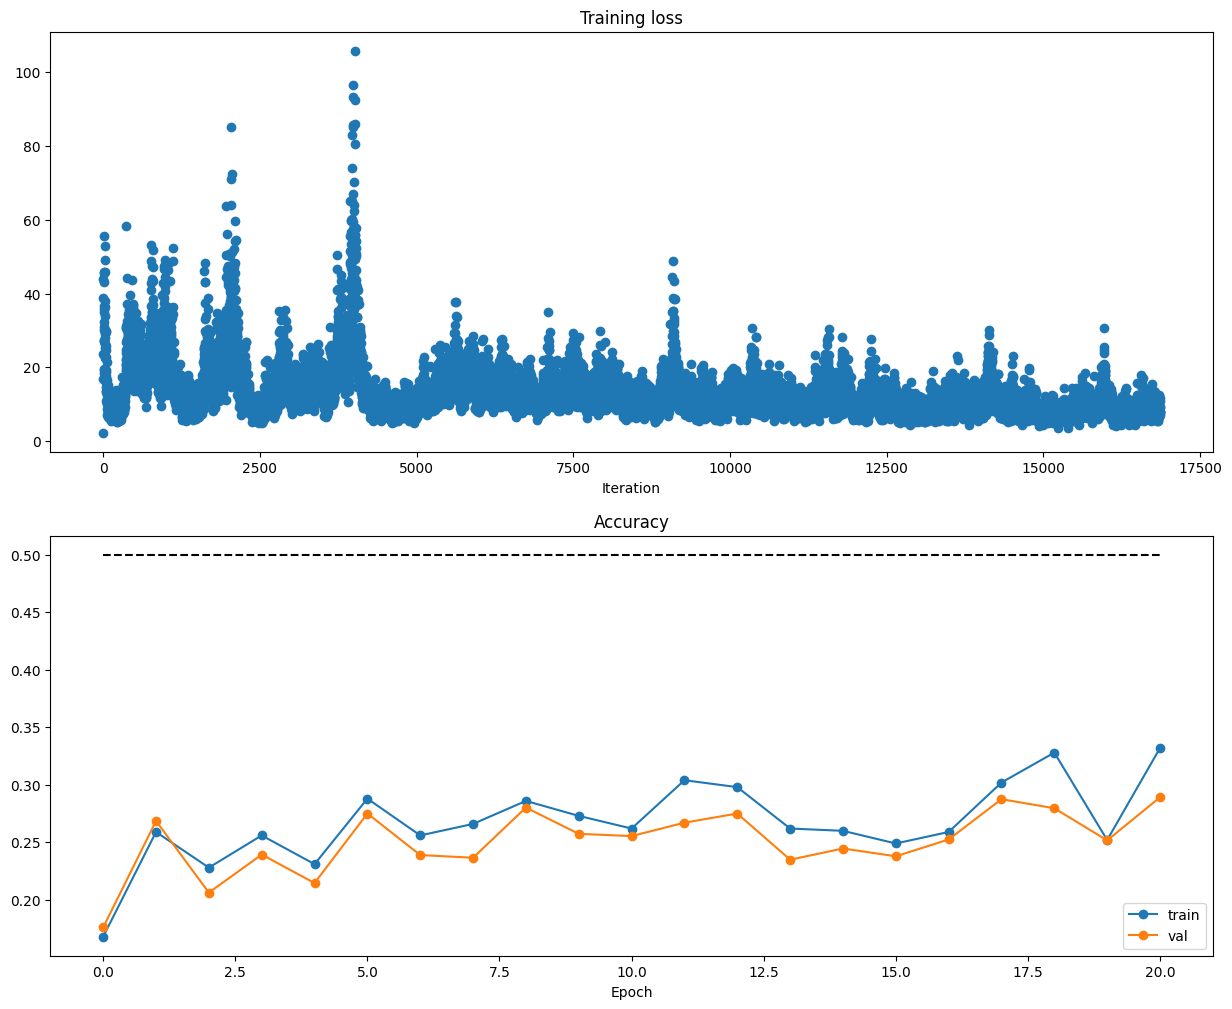

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `ece697ls/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  # Most of the errors should be on the order of e-7 or smaller.
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.90e-09
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.57e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 90+% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 1.806892
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.198431
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.206376
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.189308
(Epoch 3 / 20) train acc: 0.600000; val_acc: 0.217656
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.217656
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.186758
(Iteration 11 / 40) loss: 0.986982
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.232075
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.216381
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.227857
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.224816
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.233055
(Iteration 21 / 40) loss: 0.191172
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.234723
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.232565
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.227268
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.231878
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.234821
(Iteration 31 / 40) loss: 

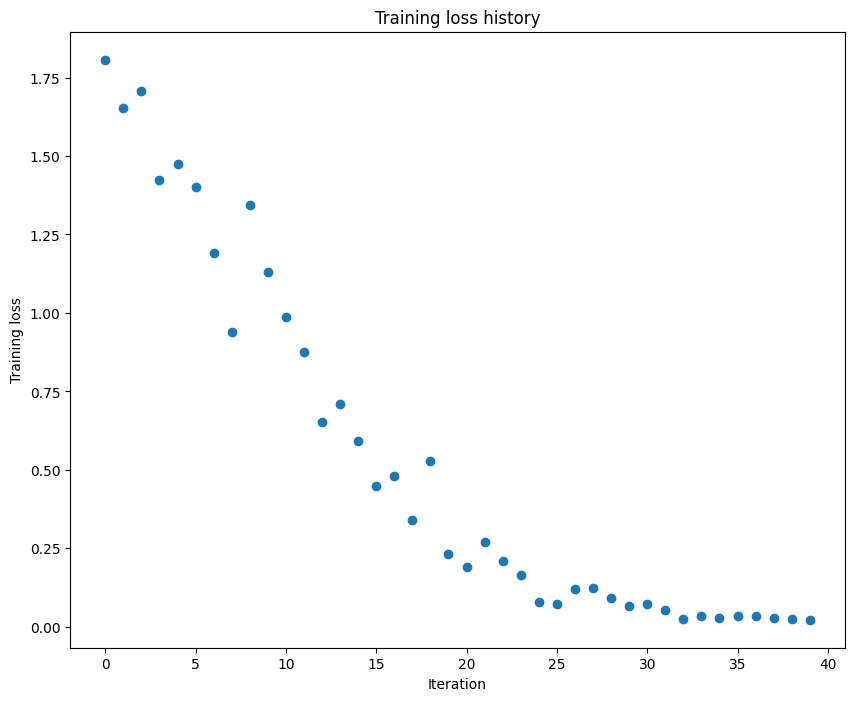

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64, num_classes=6)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 3.633970
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.166650
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.166160
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.165964
(Epoch 3 / 20) train acc: 0.620000; val_acc: 0.187739
(Epoch 4 / 20) train acc: 0.760000; val_acc: 0.210299
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.191859
(Iteration 11 / 40) loss: 1.051640
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.189799
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.191957
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.185777
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.208632
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.211672
(Iteration 21 / 40) loss: 0.067301
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.211672
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.211869
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.210397
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.212457
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.212849
(Iteration 31 / 40) loss: 

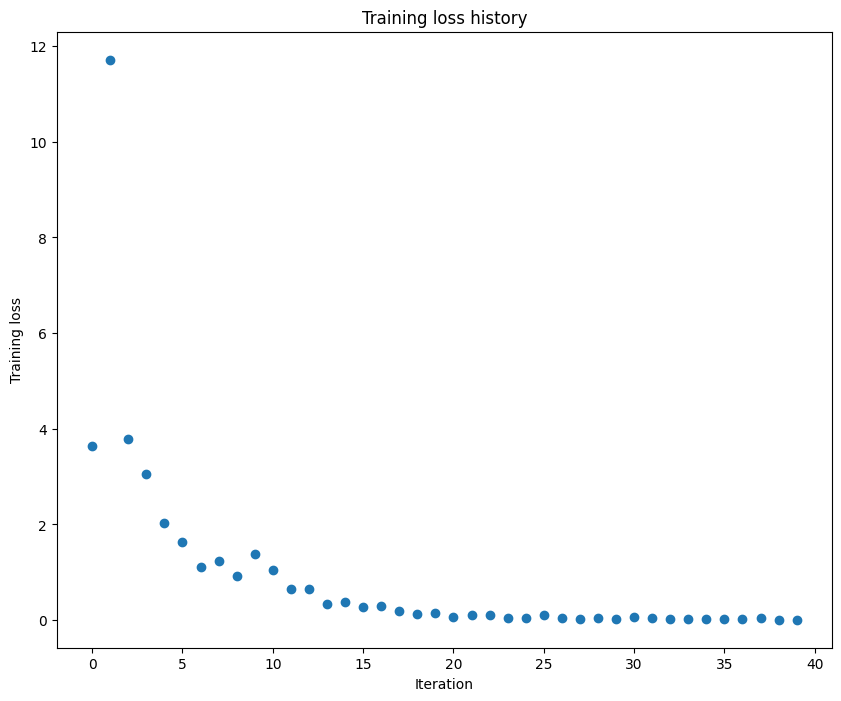

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-2  # Experiment with this!
weight_scale = 5e-2   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 3:
Why would you need multi-layer networks ? Will stacking several layers without activation functions be able to model complex problems ?

## Answer:
- Multi-layer networks is needed to model complex functions.
- Stacking several layers without activation functions, the whole network collapses to just one affine map, so it can't capture non-linear structure.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

Open the file `ece697ls/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [5]:
from ece662.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.159793
(Epoch 0 / 5) train acc: 0.174000; val_acc: 0.182737
(Iteration 11 / 200) loss: 1.777039
(Iteration 21 / 200) loss: 1.748828
(Iteration 31 / 200) loss: 1.736089
(Epoch 1 / 5) train acc: 0.273000; val_acc: 0.247278
(Iteration 41 / 200) loss: 1.721035
(Iteration 51 / 200) loss: 1.746959
(Iteration 61 / 200) loss: 1.748018
(Iteration 71 / 200) loss: 1.649587
(Epoch 2 / 5) train acc: 0.300000; val_acc: 0.271702
(Iteration 81 / 200) loss: 1.665771
(Iteration 91 / 200) loss: 1.684724
(Iteration 101 / 200) loss: 1.597036
(Iteration 111 / 200) loss: 1.676781
(Epoch 3 / 5) train acc: 0.325000; val_acc: 0.280333
(Iteration 121 / 200) loss: 1.703237
(Iteration 131 / 200) loss: 1.634990
(Iteration 141 / 200) loss: 1.553200
(Iteration 151 / 200) loss: 1.477014
(Epoch 4 / 5) train acc: 0.363000; val_acc: 0.286513
(Iteration 161 / 200) loss: 1.589003
(Iteration 171 / 200) loss: 1.605334
(Iteration 181 / 200) loss: 1.591832
(Iteration 191 / 200) los

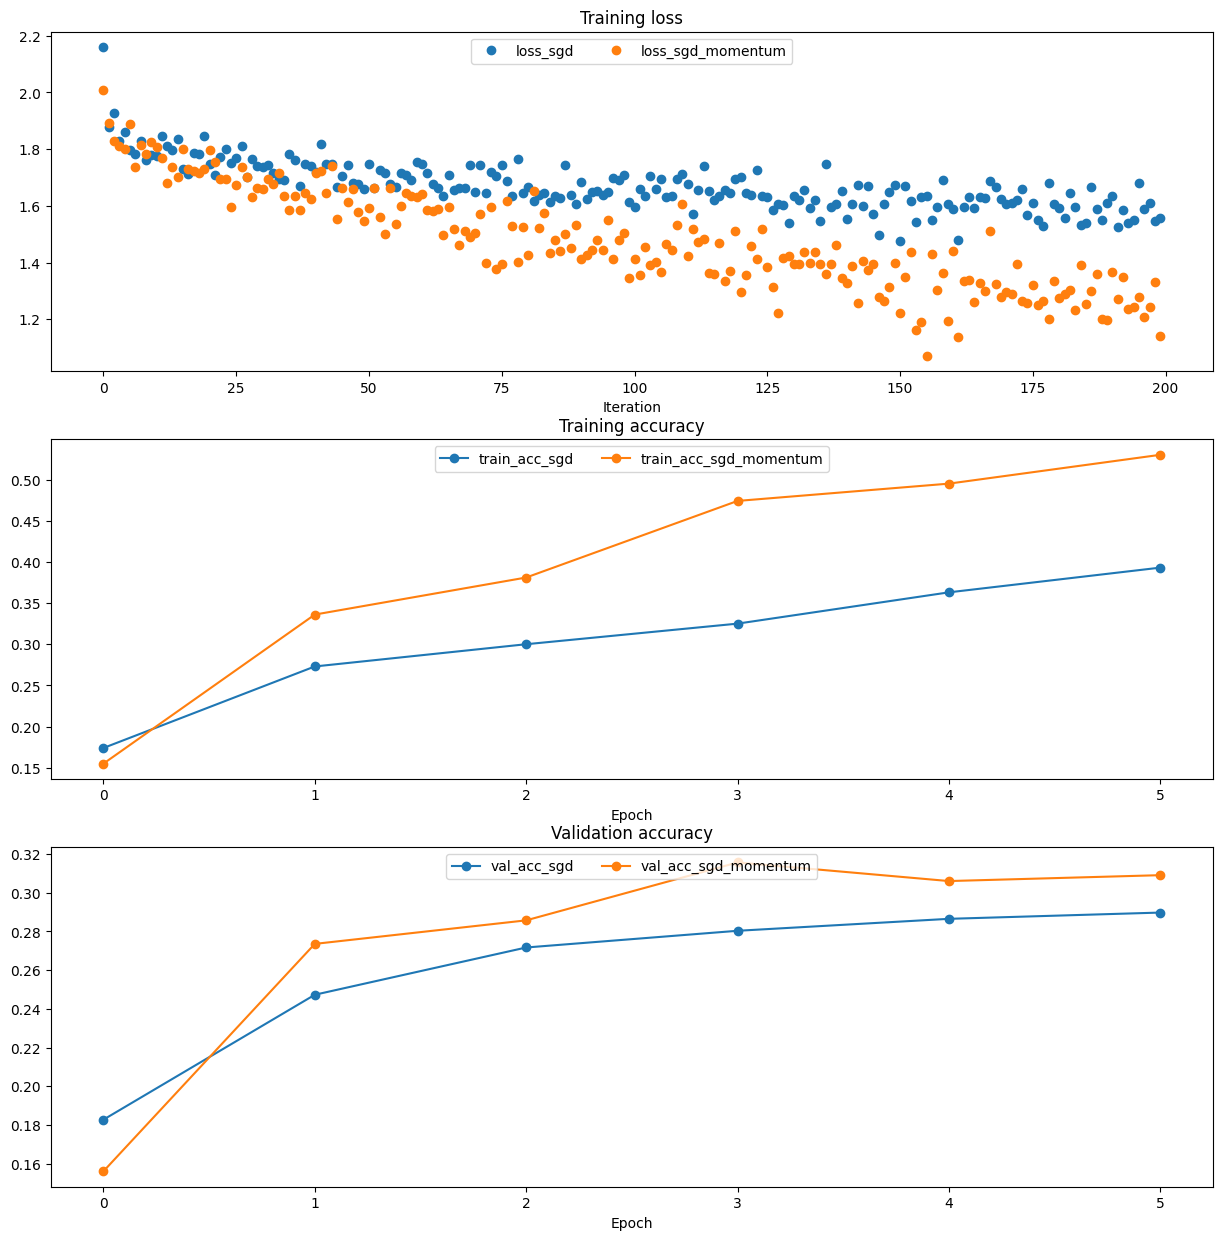

In [6]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, num_classes=6)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `ece697ls/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [11]:
# Test RMSProp implementation
from ece662.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [12]:
# Test Adam implementation
from ece662.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 1.956743
(Epoch 0 / 5) train acc: 0.197000; val_acc: 0.177146
(Iteration 11 / 200) loss: 1.698099
(Iteration 21 / 200) loss: 1.679408
(Iteration 31 / 200) loss: 1.636102
(Epoch 1 / 5) train acc: 0.345000; val_acc: 0.304953
(Iteration 41 / 200) loss: 1.634565
(Iteration 51 / 200) loss: 1.456769
(Iteration 61 / 200) loss: 1.491705
(Iteration 71 / 200) loss: 1.566699
(Epoch 2 / 5) train acc: 0.420000; val_acc: 0.317999
(Iteration 81 / 200) loss: 1.539465
(Iteration 91 / 200) loss: 1.437493
(Iteration 101 / 200) loss: 1.365292
(Iteration 111 / 200) loss: 1.586583
(Epoch 3 / 5) train acc: 0.451000; val_acc: 0.321334
(Iteration 121 / 200) loss: 1.582899
(Iteration 131 / 200) loss: 1.519849
(Iteration 141 / 200) loss: 1.191362
(Iteration 151 / 200) loss: 1.376672
(Epoch 4 / 5) train acc: 0.530000; val_acc: 0.317509
(Iteration 161 / 200) loss: 1.333433
(Iteration 171 / 200) loss: 1.237015
(Iteration 181 / 200) loss: 1.382192
(Iteration 191 / 200) lo

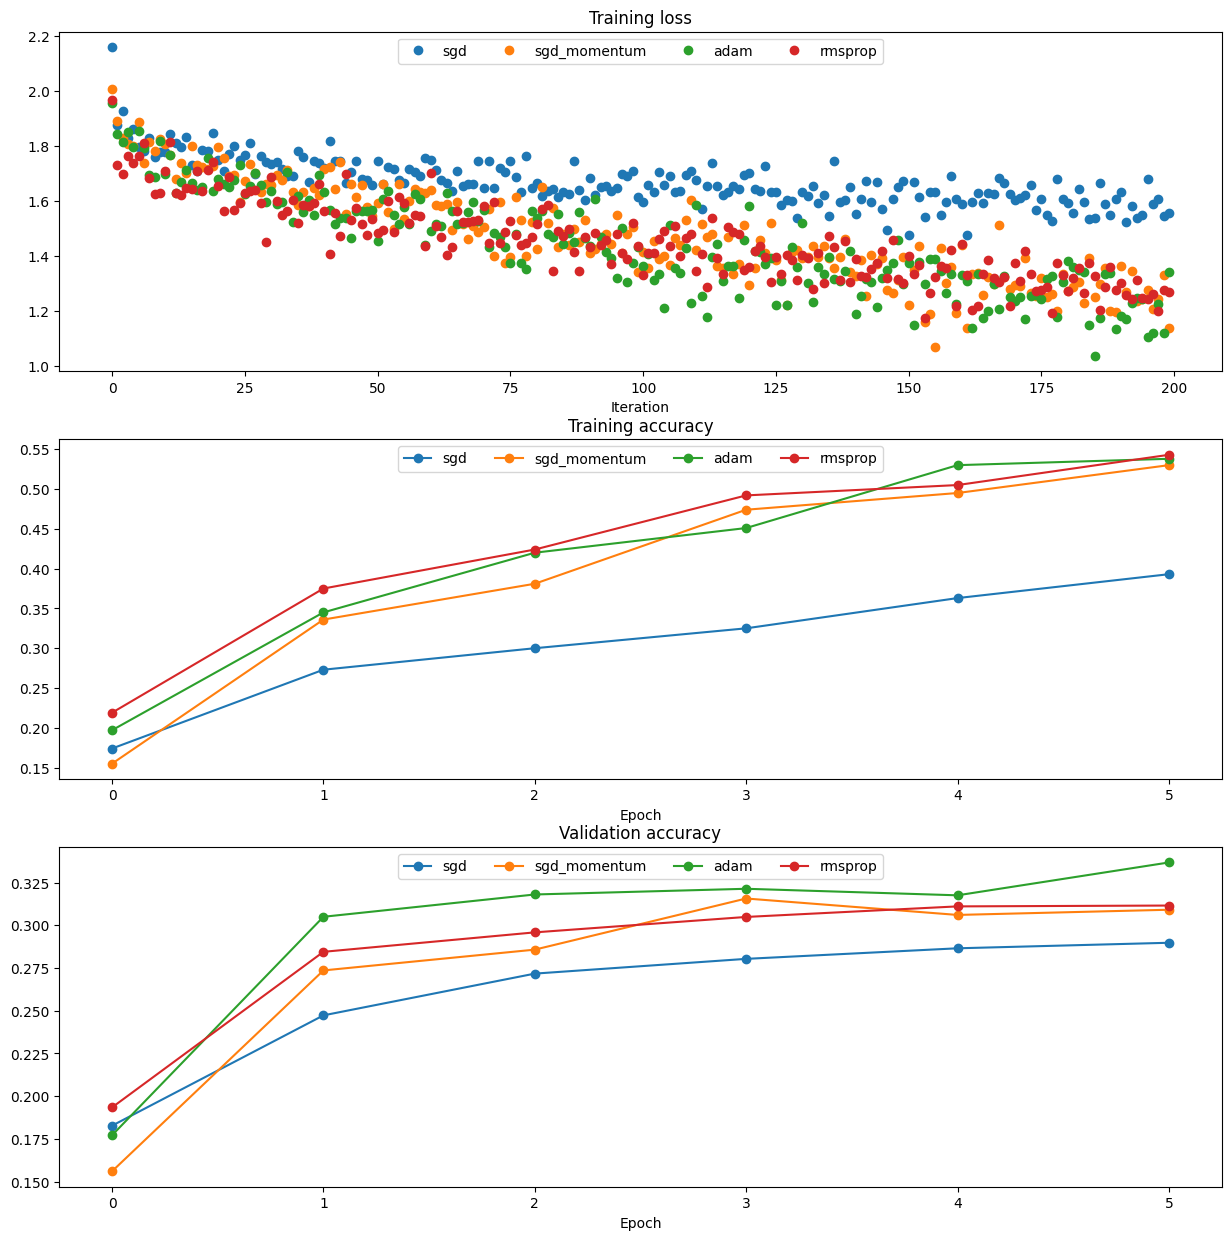

In [13]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, num_classes=6)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)

  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 4:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:
In AdaGrad, the cache accumulates the sum of squared gradients over all training iterations. The problem is that cache only grows (never shrinks) because we're always adding positive values (dw**2). As training progresses:

1. cache becomes increasingly large
2. np.sqrt(cache) in the denominator becomes large
3. The effective learning rate learning_rate / np.sqrt(cache) becomes very small
4. Weight updates dw / np.sqrt(cache) become negligible
5. This leads to the vanishing learning rate problem - the algorithm essentially stops learning because the accumulated history makes future updates too small


No, Adam does not have this issue because it uses an exponential moving average instead of simple accumulation:

m = beta1 * m + (1 - beta1) * dw        # First moment (gradient)   
v = beta2 * v + (1 - beta2) * dw**2     # Second moment (squared gradient)  

Key differences:

- Adam's v doesn't grow indefinitely because of the beta2 decay factor
- The exponential moving average gives more weight to recent gradients
- Adam includes bias correction to account for initialization at zero
- The effective learning rate doesn't vanish over time

This is why Adam generally maintains more consistent learning throughout training compared to AdaGrad.

# Train a good model!
Train the best fully-connected model that you can on CINIC-10, storing your best model in the `best_model` variable. We require you to get at least 40% accuracy on the validation set using a fully-connected net.

Later in the assignment we will ask you to train the best convolutional network that you can on CINIC-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [4]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CINIC-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Architecture: 3072 -> 512 -> 256 -> 6 classes
hidden_dims = [512, 256]

# Model configuration with dropout
best_model = FullyConnectedNet(
    hidden_dims=hidden_dims,
    input_dim=3 * 32 * 32,  # CINIC-10 images are 32x32x3
    num_classes=6,          # CINIC-10 has 6 classes
    dropout=0.90,           # Keep 90% of neurons (10% dropout)
    normalization= 'layernorm',    
    reg=1e-3,               # L2 regularization
    weight_scale=5e-2,      # Weight initialization scale
    dtype=np.float32
)

# Use Adam optimizer
solver = Solver(
    model=best_model,
    data=data,
    update_rule='adam',
    optim_config={
        'learning_rate': 1e-3,
    },
    lr_decay=0.95,
    batch_size=100,
    num_epochs=20,
    print_every=1000,
    verbose=True
)

# Train the model
solver.train()

# Store the trained model
best_model = solver.model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 10780) loss: 4.072180
(Epoch 0 / 20) train acc: 0.242000; val_acc: 0.227955
(Epoch 1 / 20) train acc: 0.397000; val_acc: 0.374399
(Iteration 1001 / 10780) loss: 1.531835
(Epoch 2 / 20) train acc: 0.429000; val_acc: 0.378225
(Epoch 3 / 20) train acc: 0.415000; val_acc: 0.378617
(Iteration 2001 / 10780) loss: 1.617152
(Epoch 4 / 20) train acc: 0.428000; val_acc: 0.405297
(Epoch 5 / 20) train acc: 0.446000; val_acc: 0.410005
(Iteration 3001 / 10780) loss: 1.464091
(Epoch 6 / 20) train acc: 0.444000; val_acc: 0.412751
(Epoch 7 / 20) train acc: 0.480000; val_acc: 0.413438
(Iteration 4001 / 10780) loss: 1.432942
(Epoch 8 / 20) train acc: 0.501000; val_acc: 0.416184
(Epoch 9 / 20) train acc: 0.507000; val_acc: 0.422658
(Iteration 5001 / 10780) loss: 1.544982
(Epoch 10 / 20) train acc: 0.508000; val_acc: 0.425699
(Epoch 11 / 20) train acc: 0.511000; val_acc: 0.422168
(Iteration 6001 / 10780) loss: 1.297682
(Epoch 12 / 20) train acc: 0.547000; val_acc: 0.419323
(Iteration 7001 / 

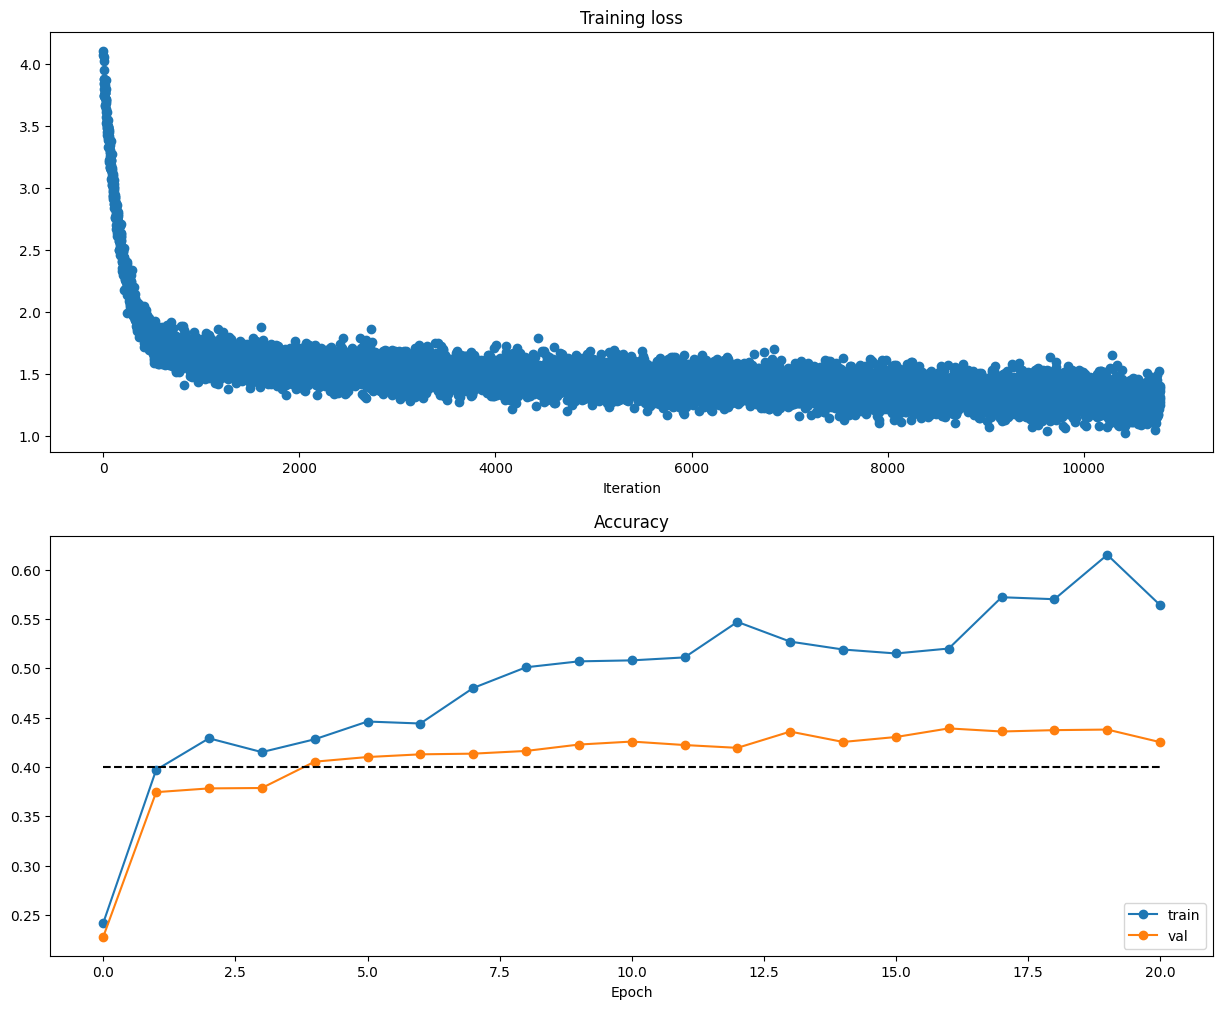

In [5]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.4] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Test your model!
Run your best model on the validation and test sets. You should achieve above 40% accuracy on the validation set.

In [6]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.4390387444825895
Test set accuracy:  0.43899568458218907
